# TP IA — Clustering (Mall Customers) — Corrigé

Ce notebook propose une solution guidée pour le dataset **Mall Customers**.
Il s'agit d'un jeu de données simple pour illustrer la segmentation de clients.

**Colonnes usuelles** : `CustomerID`, `Gender`, `Age`, `Annual Income (k$)`, `Spending Score (1-100)`.

**Plan** :
1) Chargement & exploration  
2) Mise à l'échelle & PCA (2D)  
3) K-Means (recherche de k, silhouette)  
4) DBSCAN (comparaison)  
5) Discussion rapide

> Placez **Mall_Customers.csv** dans le même dossier que ce notebook.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)

## 1) Chargement & exploration

In [2]:
# Chemin du CSV (attendu dans le même dossier)
csv_path = "Mall_Customers.csv"

df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe(include='all')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### Sélection/encodage des variables

Nous allons sélectionner : `Age`, `Annual Income (k$)`, `Spending Score (1-100)`.
On peut **ajouter `Gender`** encodé si on souhaite.

In [5]:
# Gestion de Gender (optionnel)
use_gender = True  # passez à False pour ignorer le genre

features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

if use_gender and 'Gender' in df.columns:
    le = LabelEncoder()
    df['Gender_enc'] = le.fit_transform(df['Gender'].astype(str))
    features = features + ['Gender_enc']

X = df[features].copy()
X.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_enc
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


## 2) Standardisation & PCA (2D)

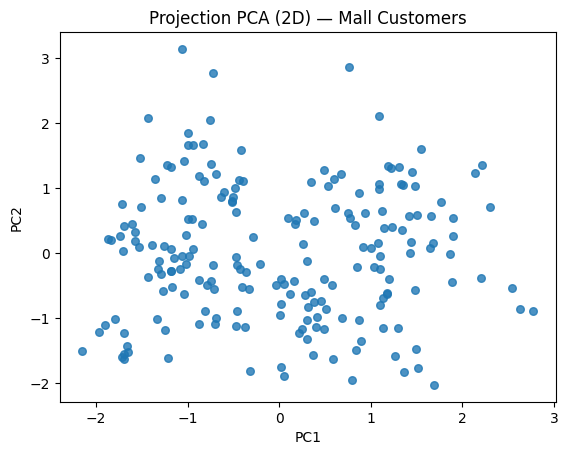

array([0.33690046, 0.26230645])

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=30, alpha=0.8)
plt.title("Projection PCA (2D) — Mall Customers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

pca.explained_variance_ratio_

## 3) K-Means — recherche de k (silhouette)

In [7]:
k_values = range(2, 9)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

list(zip(k_values, sil_scores))

[(2, 0.2776035125578273),
 (3, 0.2576199805135528),
 (4, 0.29010917402310876),
 (5, 0.27191023466188324),
 (6, 0.33475434756692174),
 (7, 0.3457397879257699),
 (8, 0.37276475942129284)]

In [8]:
# Choix du meilleur k selon la silhouette
best_idx = int(np.argmax(sil_scores))
best_k = list(k_values)[best_idx]
best_k, sil_scores[best_idx]

(8, 0.37276475942129284)

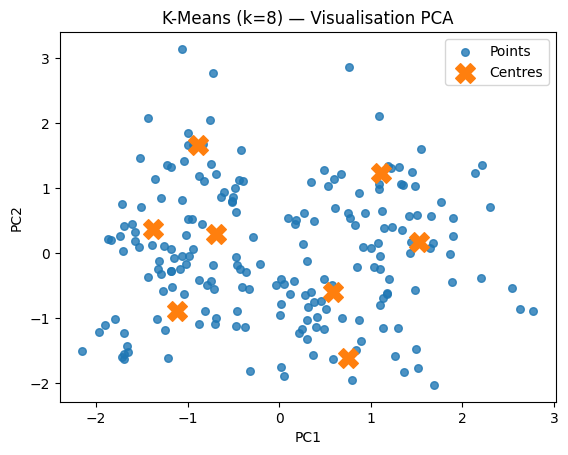

0.37276475942129284

In [9]:
# Entraînement final K-Means
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_scaled)

# Centres projetés en PCA
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=30, alpha=0.8, label="Points")
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker="X", s=200, label="Centres")
plt.title(f"K-Means (k={best_k}) — Visualisation PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

sil_km = silhouette_score(X_scaled, labels_km)
sil_km

## 4) DBSCAN — comparaison

In [10]:
# Paramètres initiaux — à ajuster si besoin
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
prop_noise = (labels_db == -1).mean()
n_clusters_db, prop_noise

(9, np.float64(0.31))

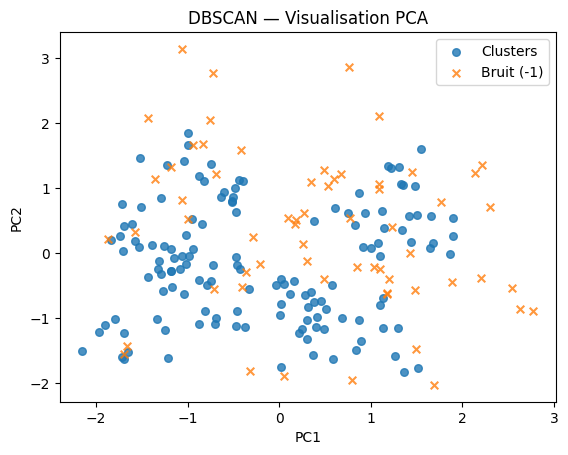

In [11]:
# Visualisation
plt.figure()
mask_core = labels_db != -1
plt.scatter(X_pca[mask_core,0], X_pca[mask_core,1], s=30, alpha=0.8, label="Clusters")
plt.scatter(X_pca[~mask_core,0], X_pca[~mask_core,1], s=30, alpha=0.8, marker="x", label="Bruit (-1)")
plt.title("DBSCAN — Visualisation PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

### Profiling simple des clusters K-Means

In [12]:
# Rejoindre les labels au DataFrame pour un profil rapide
df_clusters = df.copy()
df_clusters['cluster_km'] = labels_km
profile = df_clusters.groupby('cluster_km')[features].mean().round(2)
profile

,Age,Annual Income (k$),Spending Score (1-100),Gender_enc
cluster_km,,,,
0,58.85,48.69,39.85,1.00
1,25.25,41.25,60.92,1.00
2,41.21,26.07,20.14,0.07
3,32.19,86.05,81.67,0.00
4,50.25,63.10,41.45,0.00
5,39.04,90.61,15.39,0.83
6,25.71,44.35,60.15,0.00
7,33.28,87.11,82.67,1.00


## 5) Discussion rapide

- **K-Means** : segmentation en groupes de taille comparable, paramètre **k** à choisir (ici via silhouette).
- **DBSCAN** : identifie le **bruit** et des formes non convexes ; sensible à `eps`/`min_samples` et à l'échelle.
- **Standardisation** : essentielle ici (variables en k$ vs scores/âges).
- **Profiling** : décrire les clusters avec des moyennes (âge, revenu, spending...) pour donner du sens business.
